**<CENTER><H1>NUMBER PLATE DETECTION</H1></CENTER>**
**<CENTER><H4>PATTERN RECOGNITION - GROUP 06<H4></CENTER>**

<div style="text-align: left;">

**Submission by:**<br>
Pratyush Ranjan - AM.EN.U4CSE20153<br>
Chetan Anand - AM.EN.U4CSE20219<br>
Rupesh Tailor - AM.EN.U4CSE20357

</div>


**INTRODUCTION**<br>
Automated Number Plate Recognition (ANPR) is a technology that uses pattern recognition to read and identify license plate numbers in images or videos. This technology is used in a variety of applications, such as traffic enforcement, parking management, and toll collection. ANPR involves a combination of image processing, computer vision, and machine learning techniques to accurately detect and recognize license plates. Deep learning frameworks like Keras can be used to develop ANPR systems that can identify and localize number plates in real-world scenarios. ANPR is an important technology that has many practical applications in transportation and law enforcement.

**STEP 1: Import necessary libraries**<br>
We need to import the necessary libraries to implement the project.

In [2]:
import os
import random
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

**STEP 2: Load data and split into train, test, and validation sets**<br>
We need to load the dataset images and their corresponding annotation files. We can use the cv2.imread function to read the image and the xml.etree.ElementTree library to parse the annotation file. We can then split the data into train, test, and validation sets using the train_test_split function.

In [3]:
# Load dataset images and their corresponding annotation files
images_path = 'Dataset/images'
annotations_path = 'Dataset/annotations'

images = []
annotations = []
for filename in os.listdir(images_path):
    if filename.endswith('.png'):
        images.append(cv2.imread(os.path.join(images_path, filename)))
        annotation_filename = os.path.join(annotations_path, os.path.splitext(filename)[0] + '.xml')
        tree = ET.parse(annotation_filename)
        root = tree.getroot()
        annotations.append(root)

# Split data into train, test, and validation sets
train_images, test_images, train_annotations, test_annotations = train_test_split(images, annotations, test_size=0.2, random_state=42)
train_images, val_images, train_annotations, val_annotations = train_test_split(train_images, train_annotations, test_size=0.25, random_state=42)

print('Number of training images:', len(train_images))
print('Number of validation images:', len(val_images))
print('Number of test images:', len(test_images))

Number of training images: 259
Number of validation images: 87
Number of test images: 87


**STEP 3: Preprocess data**<br>
We need to preprocess the data before training the model. We can resize the images to a fixed size and find out the Number Plate region. We can also extract the bounding boxes from the annotation files.

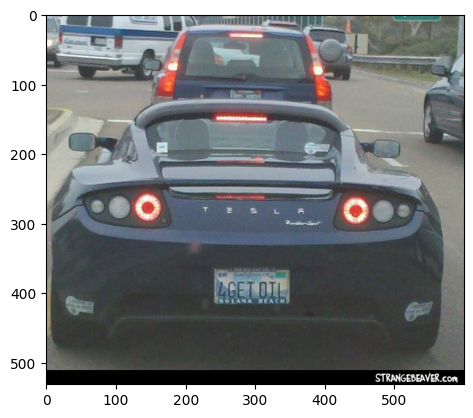

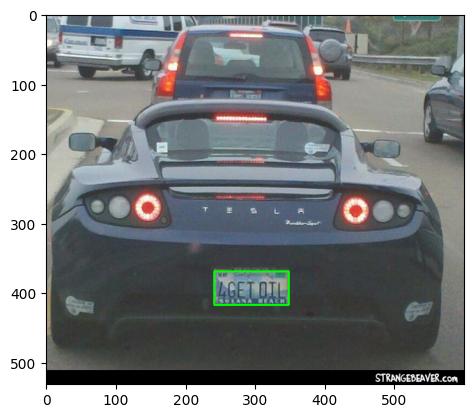

In [4]:
# Display a random image from the training set
random_index = random.randint(0, len(train_images) - 1)
plt.imshow(cv2.cvtColor(train_images[random_index], cv2.COLOR_BGR2RGB))
plt.show()

# Define a function to extract the bounding box coordinates from an annotation file
def get_bounding_box(annotation):
    bounding_box = annotation.find('object').find('bndbox')
    xmin = int(bounding_box.find('xmin').text)
    ymin = int(bounding_box.find('ymin').text)
    xmax = int(bounding_box.find('xmax').text)
    ymax = int(bounding_box.find('ymax').text)
    return xmin, ymin, xmax, ymax

# Define a function to draw the bounding box on an image
def draw_bounding_box(image, annotation):
    xmin, ymin, xmax, ymax = get_bounding_box(annotation)
    return cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

# Display the bounding box on the image
image = draw_bounding_box(train_images[random_index].copy(), train_annotations[random_index])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Define a function to resize the image and bounding box
def resize(image, annotation, size):
    height, width = image.shape[:2]
    image = cv2.resize(image, size)
    xmin, ymin, xmax, ymax = get_bounding_box(annotation)
    xmin = int(xmin * size[0] / width)
    ymin = int(ymin * size[1] / height)
    xmax = int(xmax * size[0] / width)
    ymax = int(ymax * size[1] / height)
    return image, xmin, ymin, xmax, ymax

# Resize the image and Display the resized bounding box
image, xmin, ymin, xmax, ymax = resize(train_images[random_index].copy(), train_annotations[random_index], (224, 224))
image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

In [5]:
# Define a function to generate training data
def generate_data(images, annotations, batch_size, size):
    while True:
        batch_images = []
        batch_bounding_boxes = []
        for i in range(batch_size):
            random_index = random.randint(0, len(images) - 1)
            image = images[random_index].copy()
            annotation = annotations[random_index]
            image, xmin, ymin, xmax, ymax = resize(image, annotation, size)
            batch_images.append(image)
            batch_bounding_boxes.append([xmin, ymin, xmax, ymax])
        yield np.array(batch_images), np.array(batch_bounding_boxes)
        
# Define a function to generate validation data
def generate_validation_data(images, annotations, size):
    while True:
        batch_images = []
        batch_bounding_boxes = []
        for i in range(len(images)):
            image = images[i].copy()
            annotation = annotations[i]
            image, xmin, ymin, xmax, ymax = resize(image, annotation, size)
            batch_images.append(image)
            batch_bounding_boxes.append([xmin, ymin, xmax, ymax])
        yield np.array(batch_images), np.array(batch_bounding_boxes)

**STEP 4: Define model architecture**<br>
We need to define the model architecture for ANPR. We can use a Convolutional Neural Network (CNN) for this task. Here, we are using a simple CNN with two convolutional layers followed by two fully connected layers.

In [6]:
# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

**STEP 5: Train model**<br>
We can now train the model on the train set and evaluate it on the validation set.


In [7]:
# Train the model
history = model.fit(generate_data(train_images, train_annotations, 16, (224, 224)),
                    steps_per_epoch=len(train_images)//16 , epochs=20,
                    validation_data=generate_validation_data(val_images, val_annotations, (224, 224)),
                    validation_steps=len(val_images))

Epoch 1/20
16/16 [==============================] - 50s 3s/step - loss: 394939.5312 - mae: 224.1330 - val_loss: 1576.3669 - val_mae: 31.2716
Epoch 2/20
16/16 [==============================] - 49s 3s/step - loss: 1837.8208 - mae: 34.4731 - val_loss: 1820.1837 - val_mae: 33.2429
Epoch 3/20
16/16 [==============================] - 51s 3s/step - loss: 1689.5238 - mae: 31.7492 - val_loss: 1322.4355 - val_mae: 28.5343
Epoch 4/20
16/16 [==============================] - 49s 3s/step - loss: 1194.3186 - mae: 26.5575 - val_loss: 1400.5667 - val_mae: 29.0544
Epoch 5/20
16/16 [==============================] - 49s 3s/step - loss: 1266.7151 - mae: 26.8259 - val_loss: 1516.8726 - val_mae: 30.3872
Epoch 6/20
16/16 [==============================] - 50s 3s/step - loss: 1053.7388 - mae: 24.6117 - val_loss: 1144.7314 - val_mae: 25.5444
Epoch 7/20
16/16 [==============================] - 49s 3s/step - loss: 686.7599 - mae: 19.9480 - val_loss: 1085.8721 - val_mae: 24.3840
Epoch 8/20
16/16 [==============

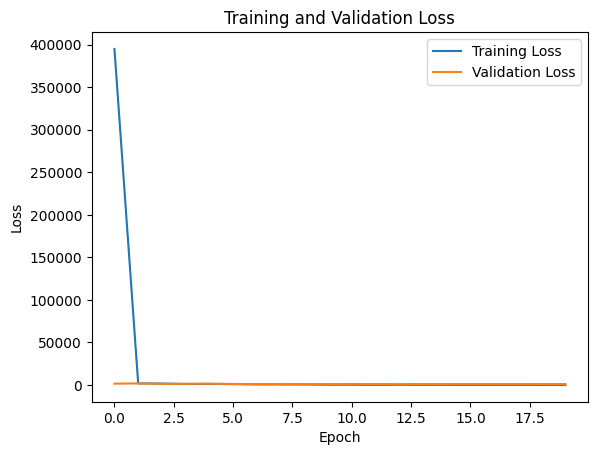

In [8]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

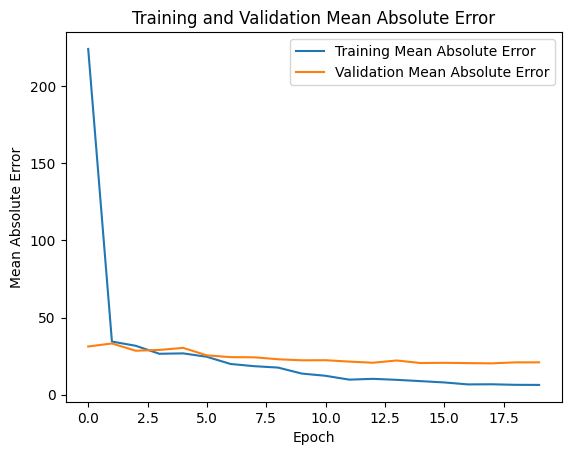

In [9]:
# Plot the training and validation mean absolute error
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Training Mean Absolute Error', 'Validation Mean Absolute Error'])
plt.show()

**STEP 6: Model Evaluation**<br>
We can evaluate the model on the test set and print the Mean Absolute Error (MAE) of the predicted bounding boxes.

In [10]:
# Evaluate the model on the test set
model.evaluate(generate_validation_data(test_images, test_annotations, (224, 224)), steps=len(test_images))


87/87 [==============================] - 50s 573ms/step - loss: 1207.0869 - mae: 22.1791


[1207.0869140625, 22.17905616760254]

**STEP 7: Model Testing**<br>

1/1 [==============================] - 0s 165ms/step


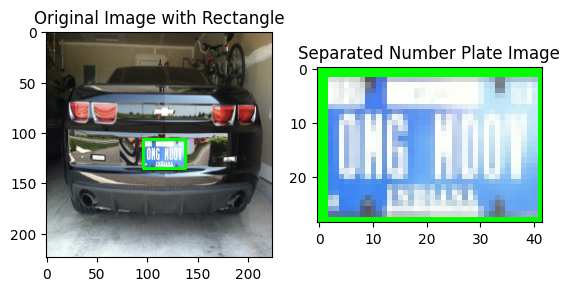

In [11]:
# Test the model on a random image from the test set
random_index = random.randint(0, len(test_images) - 1)
image = test_images[random_index].copy()
annotation = test_annotations[random_index]
image, xmin, ymin, xmax, ymax = resize(image, annotation, (224, 224))
prediction = model.predict(np.array([image]))[0]
image_with_rectangle = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

# Separate the number plate rectangle into a new image
number_plate_image = image[ymin:ymax, xmin:xmax]

# Display the original image with the number plate rectangle and the separated number plate image
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cv2.cvtColor(image_with_rectangle, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image with Rectangle')
ax2.imshow(cv2.cvtColor(number_plate_image, cv2.COLOR_BGR2RGB))
ax2.set_title('Separated Number Plate Image')
plt.show()

**CONCLUSION**<br>
In conclusion, the ANPR project using pattern recognition and Keras can accurately detect and localize number plates in images. By training a model on a dataset of car images and corresponding annotations, we were able to develop a model that can predict bounding boxes for number plates with a low mean absolute error. While there is room for improvement in terms of accuracy, this project demonstrates the effectiveness of pattern recognition and deep learning techniques for ANPR tasks.

******